In [1]:
start_date, end_date = '2022-07-10 00:00:00', '2022-07-11 00:00:00'

import xarray as xr
import pandas as pd
import numpy as np
import os
os.chdir(os.getcwd()[:-10])
from src.era5_data_retriever import ERA5DataRetriever
from src.cams_data_retrieval import CAMSDataRetriever
from datetime import datetime
import functools
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

from dotenv import load_dotenv # flemme de creer des variables d'env et les faire busculer d'un serveur à autre pour copernicus

In [2]:
ls

 Le volume dans le lecteur C s'appelle Systeme
 Le num‚ro de s‚rie du volume est 3CBC-B9B9

 R‚pertoire de C:\Users\fedi_\PycharmProjects\meteodata

11/10/2023  11:15    <DIR>          .
11/10/2023  11:15    <DIR>          ..
09/10/2023  16:40    <DIR>          .idea
10/10/2023  17:05    <DIR>          .ipynb_checkpoints
11/10/2023  11:16       363ÿ180ÿ809 data_file_2022-07-10.csv
10/10/2023  18:57        20ÿ001ÿ836 download.nc
11/10/2023  09:34       508ÿ039ÿ276 download_pollen_forcasts.nc
11/10/2023  01:20     1ÿ102ÿ455ÿ995 interactive_map.html
11/10/2023  02:05        24ÿ658ÿ165 interactive_map_corrected.html
11/10/2023  02:23        20ÿ728ÿ621 interactive_map_corrected_bright.html
09/10/2023  10:36               542 main.py
16/10/2015  21:38             1ÿ698 MOZART-MOSAIC.inp
16/10/2015  21:40               973 MOZCART.inp
11/10/2023  11:17    <DIR>          notebooks
11/10/2023  03:08        91ÿ375ÿ248 random_data.nc
11/10/2023  03:08        45ÿ692ÿ364 random_data2.nc
16/10/2015 

In [3]:
df = pd.read_csv("data_file_2022-07-10.csv")

In [4]:
df.head(3)

,time,temperature,relative_humidity,chocho_conc,co_conc,dust,ecres_conc,ectot_conc,hcho_conc,nh3_conc,...,pm10_conc,pm2p5_conc,pmwf_conc,sia_conc,so2_conc,average_pollen_concentration,average_pollen_c_,average_pollen_c_1,longitude,latitude
0,2022-07-10 12:00:00,273.42755,82.51979,0.00014,124.72867,0.000227,6.219987e-21,0.000001,0.14259,0.000014,...,2.968837,1.426107,4.103644e-21,0.071435,0.785839,0.000165,0.000165,0.000165,-0.037491,76.462498
1,2022-07-10 12:00:00,273.49930,82.24930,0.00014,124.72867,0.000227,6.219987e-21,0.000001,0.14259,0.000014,...,2.968837,1.426107,4.103644e-21,0.071435,0.785839,0.000165,0.000165,0.000165,-0.037491,76.399998
2,2022-07-10 12:00:00,273.48758,83.57790,0.00014,124.72867,0.000227,6.219987e-21,0.000001,0.14259,0.000014,...,2.968837,1.426107,4.103644e-21,0.071435,0.785839,0.000165,0.000165,0.000165,-0.037491,76.337498


In [10]:
df.describe()

,temperature,relative_humidity,chocho_conc,co_conc,dust,ecres_conc,ectot_conc,hcho_conc,nh3_conc,nmvoc_conc,no2_conc,no_conc,o3_conc,pans_conc,pm10_conc,pm2p5_conc,pmwf_conc,sia_conc,so2_conc,average_pollen_concentration,average_pollen_c_,average_pollen_c_1,longitude,latitude
count,1.264725e+06,1.264725e+06,1.264725e+06,1.264725e+06,1.264725e+06,1.264725e+06,1.264725e+06,1.264725e+06,1.264725e+06,1.264725e+06,1.264725e+06,1.264725e+06,1.264725e+06,1.264725e+06,1.264725e+06,1.264725e+06,1.264725e+06,1.264725e+06,1.264725e+06,1.264725e+06,1.264725e+06,1.264725e+06,1.264725e+06,1.264725e+06
mean,2.851889e+02,7.547467e+01,1.429498e-03,1.037130e+02,2.671188e+00,2.383176e-03,1.769237e-02,2.787140e-01,2.451685e-03,2.969084e+00,1.771887e-01,2.630125e-02,8.159133e+01,5.050122e-01,8.756221e+00,4.845354e+00,3.212009e-03,2.147965e+00,1.780045e+00,2.467191e-01,2.466980e-01,2.466980e-01,6.349703e+00,3.155232e+01
std,1.599006e+01,2.078995e+01,3.201141e-03,1.800264e+01,5.784759e+00,7.102780e-03,2.502210e-02,1.803391e-01,1.788689e-02,1.534855e+00,3.388569e-01,4.753123e-02,8.895404e+00,3.783038e-01,8.169429e+00,4.533025e+00,7.714378e-03,2.794571e+00,2.692475e+00,1.187611e+00,1.187480e+00,1.187480e+00,4.754199e+01,2.314224e+01
min,2.280936e+02,-5.801620e-01,1.485723e-06,6.571684e+01,2.352564e-08,6.219987e-21,1.000000e-06,1.394349e-02,0.000000e+00,5.696435e-01,2.876797e-03,1.603849e-11,3.195541e+01,1.121096e-02,3.828020e-01,3.590301e-01,4.103644e-21,4.757051e-03,5.116194e-04,2.293840e-20,2.290000e-20,2.290000e-20,-6.371251e+01,3.749943e-02
25%,2.754100e+02,6.552907e+01,6.676015e-06,8.386654e+01,9.379399e-04,6.219987e-21,2.332268e-06,1.324771e-01,0.000000e+00,2.169402e+00,2.607779e-02,4.320100e-03,7.503384e+01,7.509741e-02,3.539374e+00,1.627242e+00,4.103644e-21,2.206057e-01,1.455192e-01,3.054738e-04,3.050000e-04,3.050000e-04,-3.915001e+01,1.253750e+01
50%,2.886267e+02,8.010657e+01,1.971556e-04,1.086784e+02,3.666424e-03,1.908196e-04,7.949142e-03,2.346423e-01,0.000000e+00,2.300749e+00,6.226396e-02,6.757261e-03,8.413931e+01,5.479263e-01,3.864859e+00,2.077410e+00,1.110223e-06,3.751186e-01,3.217977e-01,6.176114e-03,6.180000e-03,6.180000e-03,3.250000e+00,2.510000e+01
75%,2.974686e+02,9.048080e+01,2.380943e-03,1.118850e+02,4.636007e+00,1.745826e-03,3.299017e-02,4.766632e-01,1.376677e-05,4.386795e+00,2.420526e-01,5.413270e-02,8.752023e+01,9.116838e-01,1.743905e+01,9.863378e+00,9.094947e-04,3.876673e+00,2.431875e+00,3.653765e-02,3.650000e-02,3.650000e-02,5.408750e+01,5.046250e+01
max,3.239724e+02,1.593586e+02,1.030842e-01,2.437999e+02,6.205991e+01,4.652919e-01,5.587375e-01,1.259911e+00,1.133060e+00,2.255281e+01,2.230588e+01,7.711823e+00,9.963975e+01,2.198853e+00,6.224339e+01,2.181769e+01,1.901365e+00,1.107882e+01,5.505353e+01,4.780418e+01,4.780000e+01,4.780000e+01,7.865000e+01,7.646250e+01


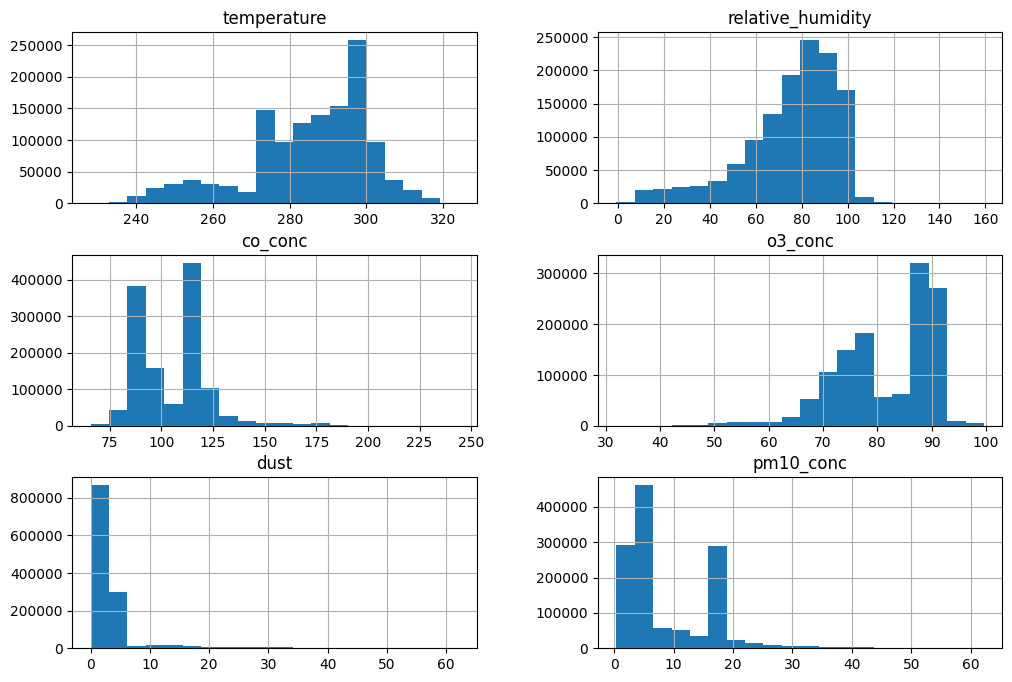

In [13]:
numeric_vars = ['temperature', 'relative_humidity', 'co_conc', 'o3_conc', 'dust', 'pm10_conc']
df[numeric_vars].hist(bins=20, figsize=(12, 8))
plt.show()

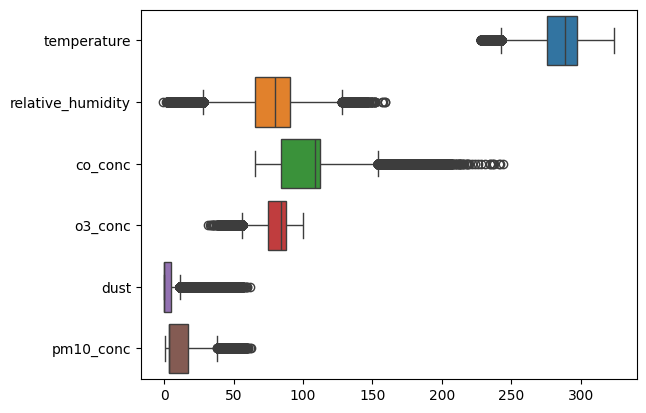

In [17]:
sns.boxplot(data=df[numeric_vars], orient='h')
plt.show()

conclusion: (pas trop fiable quand meme)
trops de valeurs outlier, beaucoup d'ecart à la moyenne, ça peut etre expliqué par le faite que les données sont aussi indexés spatialement et pas que temporellement (la merde des données de panel)


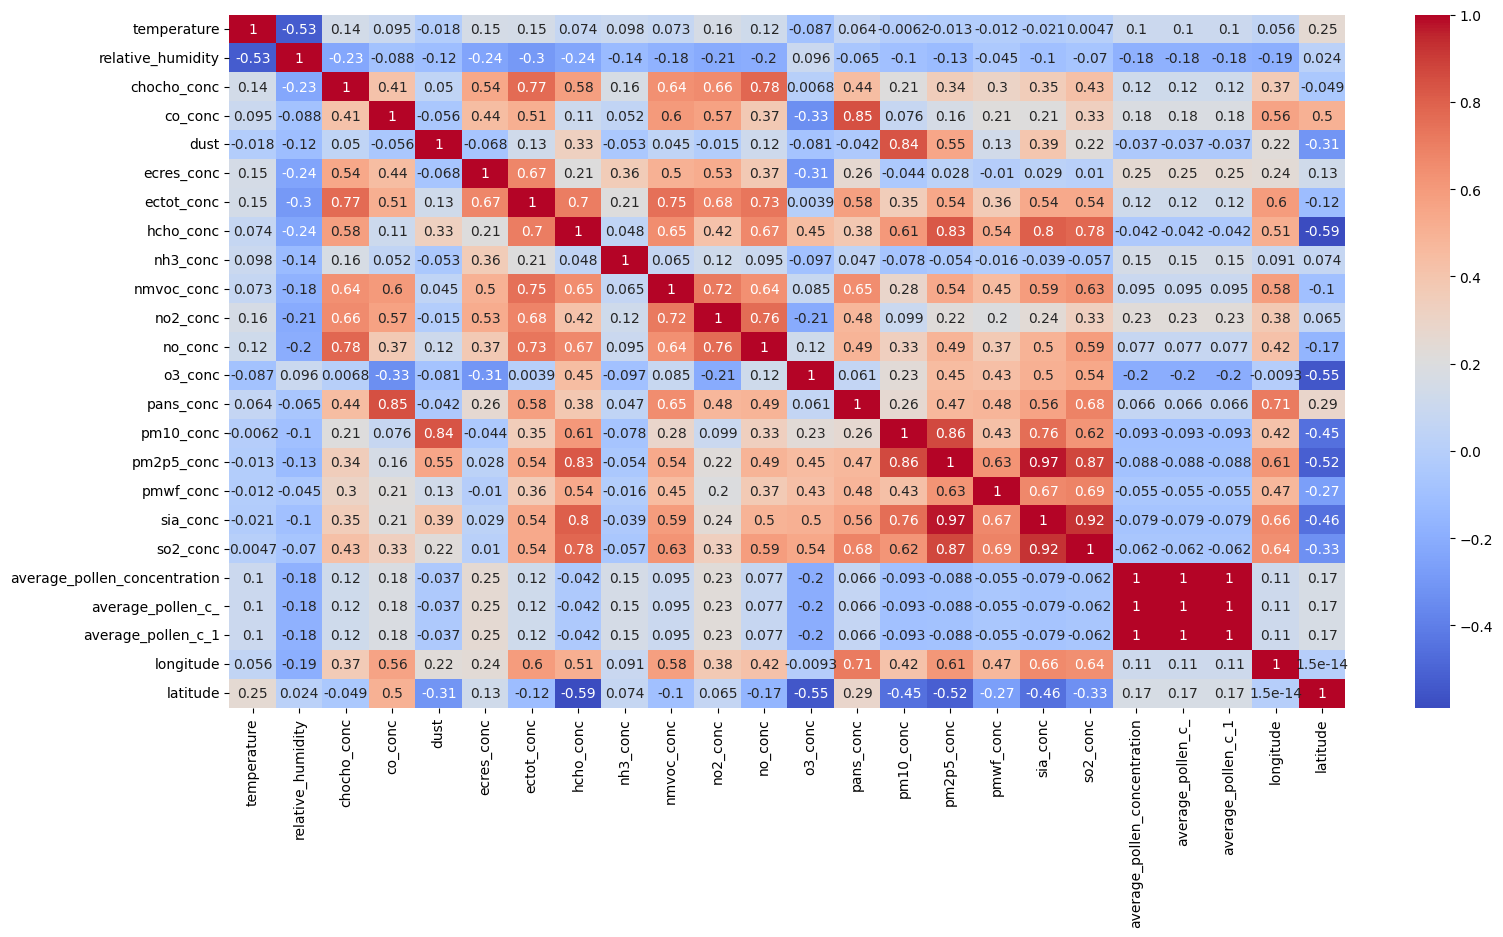

In [25]:
plt.figure(figsize=(18, 9))
correlation_matrix = df.loc[:,~df.columns.isin(['time'])].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

conclusion season 2: des correlations entre variables endogénes (rien à foutre) ça peut impacter la modélisation en introduisant des vraiances non necessaire (à revoir) 

le vif du sujet des faibles correlation avec la variable "target" qui est la concentration moyenne de pollen :D prehapes on peut avoir de bon resultat.

In [27]:
df.columns

Index(['time', 'temperature', 'relative_humidity', 'chocho_conc', 'co_conc',
       'dust', 'ecres_conc', 'ectot_conc', 'hcho_conc', 'nh3_conc',
       'nmvoc_conc', 'no2_conc', 'no_conc', 'o3_conc', 'pans_conc',
       'pm10_conc', 'pm2p5_conc', 'pmwf_conc', 'sia_conc', 'so2_conc',
       'average_pollen_concentration', 'average_pollen_c_',
       'average_pollen_c_1', 'longitude', 'latitude'],
      dtype='object')

je decide d'eliminer le facteur temporel pour l'instant

In [39]:
X = df[['temperature', 'relative_humidity', 'chocho_conc', 'co_conc',
       'dust', 'ecres_conc', 'ectot_conc', 'hcho_conc', 'nh3_conc',
       'nmvoc_conc', 'no2_conc', 'no_conc', 'o3_conc', 'pans_conc',
       'pm10_conc', 'pm2p5_conc', 'pmwf_conc', 'sia_conc', 'so2_conc']]

In [40]:
y = df['average_pollen_concentration']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


In [42]:
model_rf = RandomForestRegressor() # le choix le plus con quoi cest de faire condiance à ce genre de model
model_rf.fit(X_train, y_train)

RandomForestRegressor()

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [44]:
y_pred = model_rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

Mean Absolute Error: 0.030501620625733902
Root Mean Squared Error: 0.2675109681215813


In [45]:
y_pred

array([1.87514859e+00, 3.05473800e-04, 5.75460800e-02, ...,
       1.61039350e-01, 3.05473800e-04, 7.62939450e-06])

In [49]:
max(y_test.values), min(y_test.values) 

(47.64393, 2.2938397e-20)

In [53]:
y_test.values.std()

1.1826501091941908

c'est horrible !! le pire model, la moyenne de l'ecart de la prediction de la realité est plus important en terme d'ordre de grandeur que la realité. je centre et reduit les X, et voi si ça perssiste

In [54]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

In [55]:
model_rf_bis = RandomForestRegressor()
model_rf_bis.fit(X_train_scaled, y_train)

RandomForestRegressor()

In [56]:
y_pred_sc = model_rf_bis.predict(X_test_scaled)
mae_sc = mean_absolute_error(y_test, y_pred)
rmse_sc = mean_squared_error(y_test, y_pred, squared=False)

print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

Mean Absolute Error: 0.030501620625733902
Root Mean Squared Error: 0.2675109681215813


In [59]:
model_filename = 'models/random_forest_dumb_model.pkl'
joblib.dump(model_rf_bis, model_filename)

['random_forest_dumb_model.pkl']